In [1]:
# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

import numpy as np
import os, glob
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import ttest_ind

In [2]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)

In [3]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='Concepts/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors

In [4]:
def assemble_concept(name, id, concepts_path="Concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [5]:
concepts_path = "Concepts/"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("honeycombed", 1, concepts_path=concepts_path)

random_0_concept = assemble_concept("random_1", 2, concepts_path=concepts_path)
random_1_concept = assemble_concept("random_2", 3, concepts_path=concepts_path)

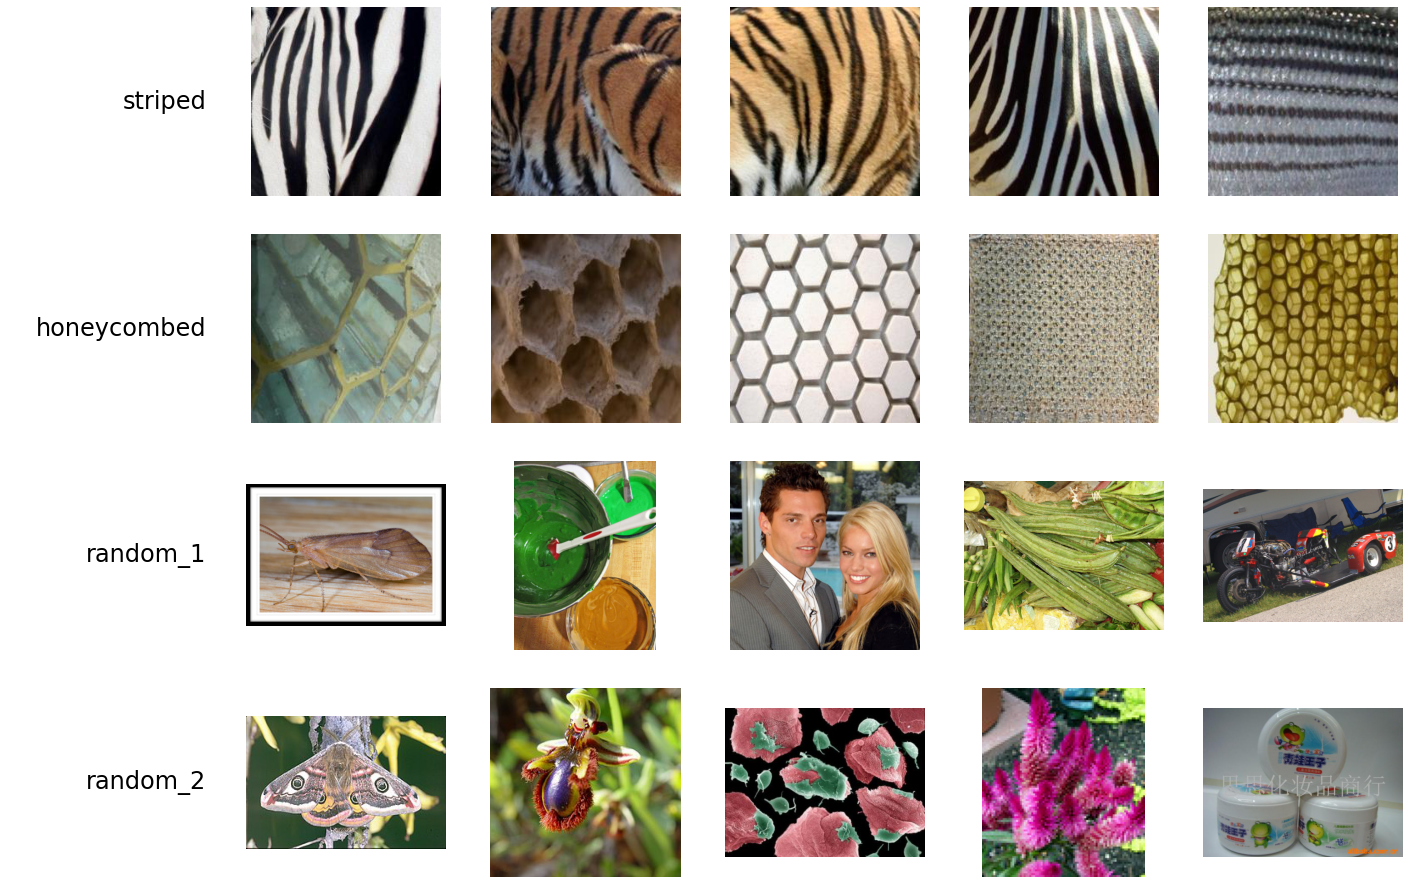

In [6]:
n_figs = 5
n_concepts = 4

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [7]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
layers=['inception4c', 'inception4d', 'inception4e']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

C:\Users\User\anaconda3\lib\site-packages\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [9]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]

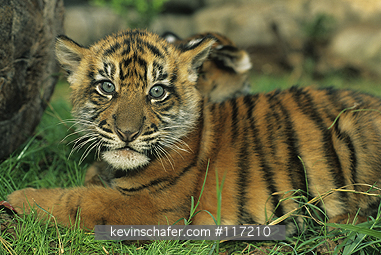

In [10]:
# Load sample images from folder
tiger_imgs = img = Image.open("Concepts/tiger/1.jpg").convert('RGB')
tiger_imgs

In [11]:
# Load sample images from folder
tiger_tensors = transform(img)
experimental_set_rand

[[Concept(0, 'striped'), Concept(2, 'random_1')],
 [Concept(0, 'striped'), Concept(3, 'random_2')]]

In [12]:
# tiger class index
tiger_ind = 293


tcav_scores_w_random = mytcav.interpret(inputs=tiger_tensors.unsqueeze(0),
                                        experimental_sets=experimental_set_rand,
                                        target=tiger_ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-2': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-2.0876,  2.0876])},
                          'inception4d': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-0.8594,  0.8594])},
                          'inception4e': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-0.9566,  0.9566])}}),
             '0-3': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-2.3812,  2.3812])},
                          'inception4d': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-2.1530,  2.1530])},
                          'inception4e': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([

In [13]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

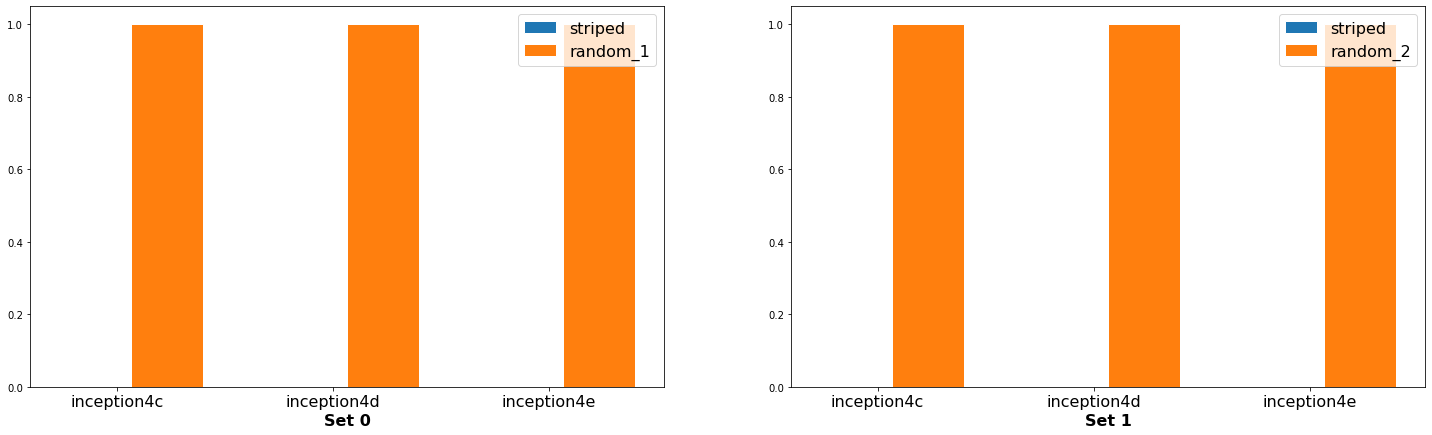

In [14]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

In [15]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept]]

In [16]:
tcav_scores_w_zig_dot = mytcav.interpret(inputs=tiger_tensors.unsqueeze(0),
                                         experimental_sets=experimental_set_zig_dot,
                                         target=tiger_ind,
                                         n_steps=5)

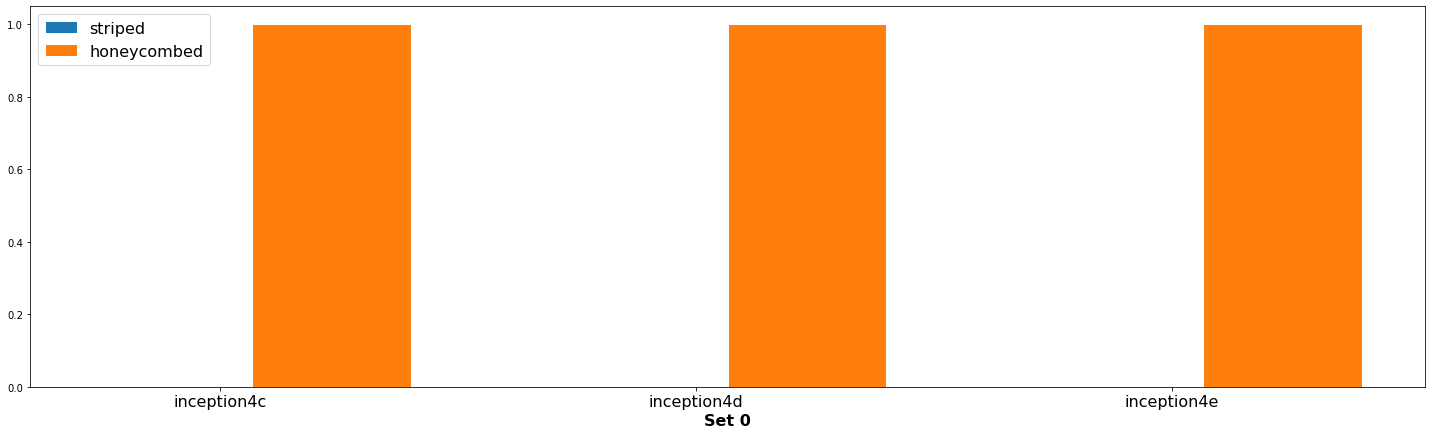

In [17]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot)    

In [18]:
n = 1

random_concepts = [assemble_concept('random_' + str(i+2), i+5) for i in range(0, n)]

print(random_concepts)

experimental_sets = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]
experimental_sets.extend([[stripes_concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([random_0_concept, random_1_concept])
experimental_sets.extend([[random_0_concept, random_concept] for random_concept in random_concepts])

experimental_sets

[Concept(5, 'random_2')]


[[Concept(0, 'striped'), Concept(2, 'random_1')],
 [Concept(0, 'striped'), Concept(3, 'random_2')],
 [Concept(0, 'striped'), Concept(5, 'random_2')],
 [Concept(2, 'random_1'), Concept(3, 'random_2')],
 [Concept(2, 'random_1'), Concept(5, 'random_2')]]

In [19]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])
        
    return score_list

In [20]:
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):
    
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)
    
    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")
        
    return P1, P2, format_float(pval), relation

In [21]:
# Run TCAV
scores = mytcav.interpret(tiger_tensors.unsqueeze(0), experimental_sets, tiger_ind, n_steps=5)

In [22]:
scores

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-2': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-2.0876,  2.0876])},
                          'inception4d': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-0.8594,  0.8594])},
                          'inception4e': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-0.9566,  0.9566])}}),
             '0-3': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-2.3812,  2.3812])},
                          'inception4d': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-2.1530,  2.1530])},
                          'inception4e': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([

In [23]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


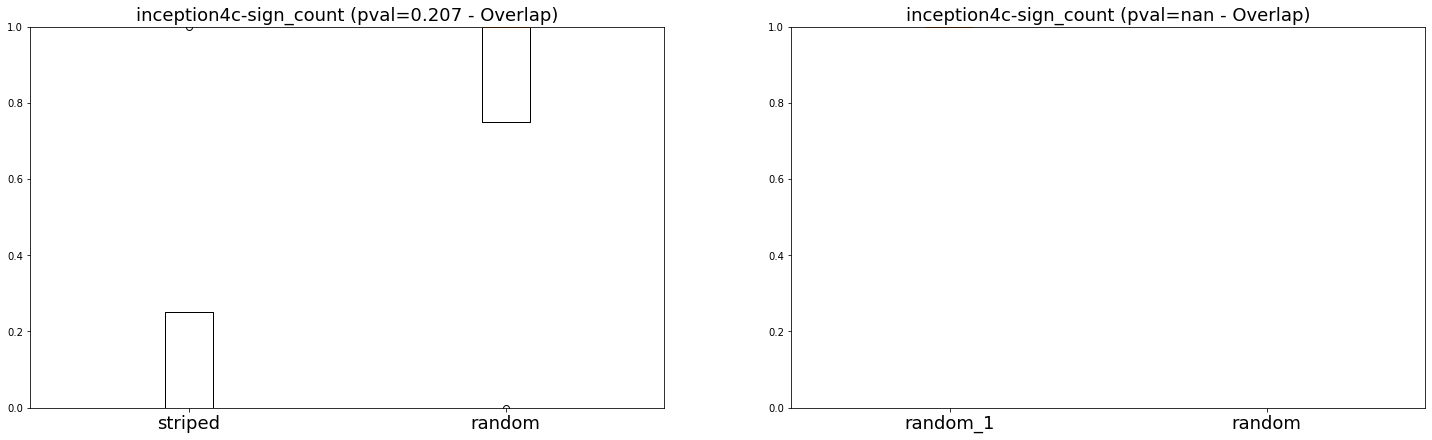

In [24]:
show_boxplots("inception4c")

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


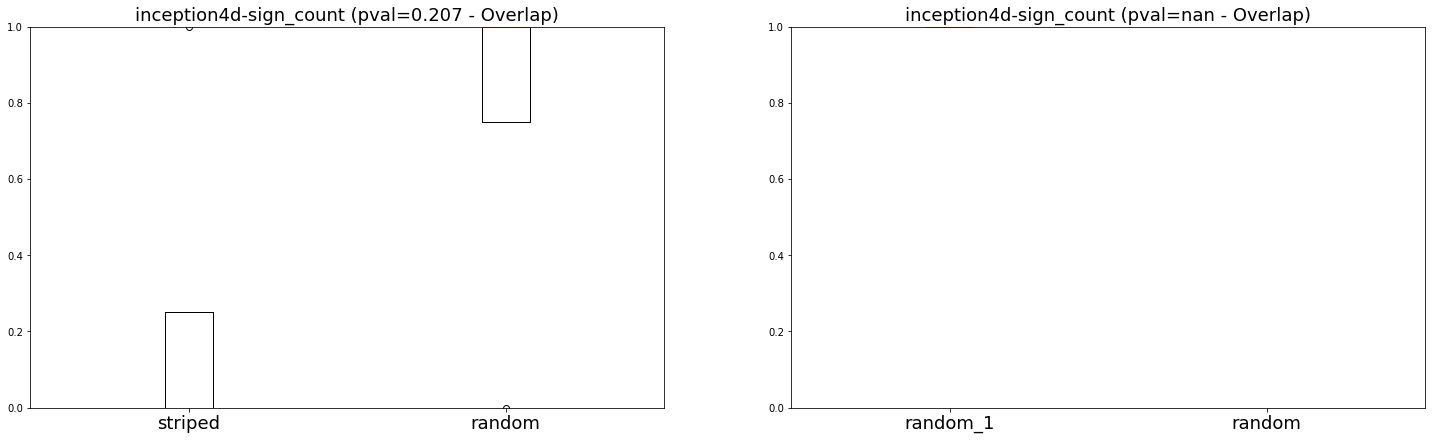

In [25]:
show_boxplots ("inception4d")

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


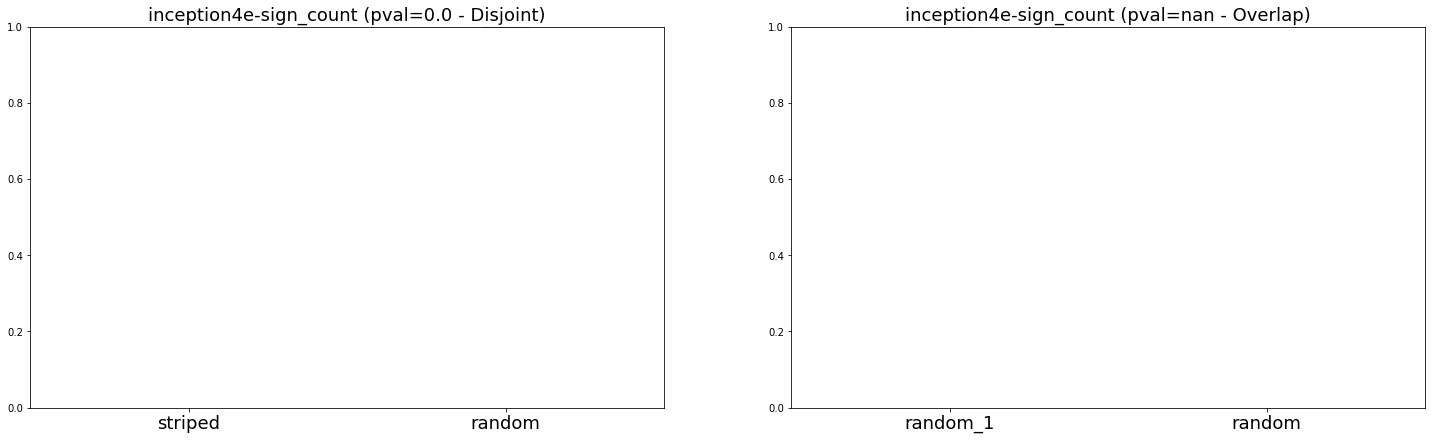

In [26]:
show_boxplots ("inception4e")